In [1]:
from args_experiments import *
from models import *
from load_data import *
from training import *
from utils import *

import random
import os
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

In [2]:
args = args_springs()
args_encoder = args_seq2graph()

Namespace(batch_size=64, cuda=True, device=device(type='cuda'), epochs_adam=1000, hidden_GC=[], lag=2, lmbd_prox=0.001, lmbd_ridge=0.001, lr=0.0005, num_atoms=10, path='/data/tsi/analyse_de_donnees/04-Data/Springs/Datasets/non_stationary/avec_overlap/multiple_trajectories/', prediction_steps=1, proximal_gradient=True, seed=1234, sparsity_min=0.1, stationary=True, suffix='_springs10')
Namespace(batch_size=64, encoder_hidden=64, epochs=600, lmbda=0.001, lr=0.0005, tau=0.5)


In [3]:
if args.suffix == '_springs10':
    train_loader, valid_loader, test_loader = load_springs_data(path=args.path, batch_size=args_encoder.batch_size,
                                                                dataset_name=args.suffix, shuffle=True)
elif args.suffix == '_cmapss_001':
    train_loader, valid_loader, test_loader = load_cmapss_data(args.path, args_encoder.batch_size,
                                                               args.time_steps, shuffle=True)

/data/tsi/analyse_de_donnees/04-Data/Springs/Datasets/non_stationary/avec_overlap/multiple_trajectories/ _springs10


In [4]:
args.num_atoms, args.time_steps, args.in_dim = train_loader.dataset[0][0].shape
if len(args.hidden_GC) > 0:
    args.first_hidden = args.hidden_GC[0]
else:
    args.first_hidden = 1

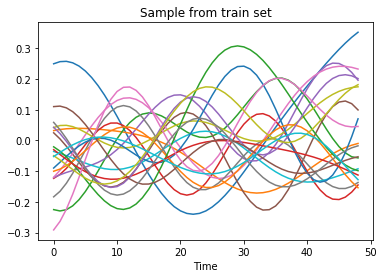

In [5]:
plt.plot(train_loader.dataset[0][0].transpose(1, 2).reshape(20, 49).numpy().T);
plt.xlabel('Time')
plt.title('Sample from train set');

### GL-VAR model

In [6]:
g = GC(G_i, args.num_atoms, args.hidden_GC, 1, lag=args.lag, activation=nn.ReLU()).to(args.device)
g.load_state_dict(torch.load(os.getcwd() + '/weights_springs10/g' + args.suffix + '.pt'))

/home/epineau/anaconda3/envs/edouard/lib/python3.6/site-packages/torch/cuda/__init__.py:116: UserWarning: 
    Found GPU0 Quadro K4000 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


In [7]:
W_prior = torch.stack([m.layers[0].weight.squeeze(-1) for m in g.model_list])
adjacency = (W_prior.sum(-1).sum(1) != 0).float().unsqueeze(1).unsqueeze(-1)
print('Sparsity: {:.2f}'.format(adjacency.mean().item()))

Sparsity: 1.00


Epoch: 0025 mse: 0.00633 ridge: 21.61701 reg: 21.77422 sparsity: 0.39


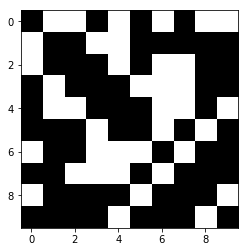

Epoch: 0050 mse: 0.00805 ridge: 21.60755 reg: 21.71816 sparsity: 0.44


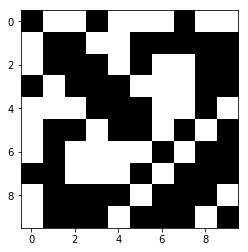

Epoch: 0075 mse: 0.00994 ridge: 21.59811 reg: 21.66557 sparsity: 0.49


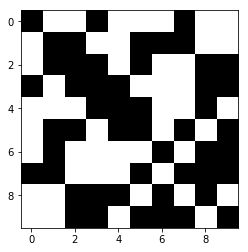

Epoch: 0100 mse: 0.01603 ridge: 21.58870 reg: 21.62000 sparsity: 0.60


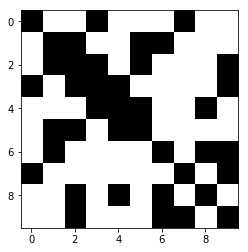

Epoch: 0125 mse: 0.01736 ridge: 21.57930 reg: 21.58832 sparsity: 0.78


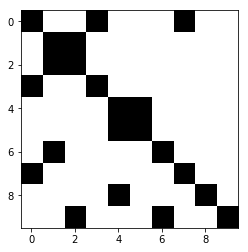

Fine tuning for saved weights
Sparsity: 1.00, loss: 0.00001
Sparsity: 0.05, loss: 0.0000
Sparsity: 0.10, loss: 0.0000
Sparsity: 0.15, loss: 0.0000
Sparsity: 0.20, loss: 0.0000
Sparsity: 0.25, loss: 0.0000
Sparsity: 0.30, loss: 0.0000
Sparsity: 0.35, loss: 0.0000
Sparsity: 0.40, loss: 0.0000
Sparsity: 0.45, loss: 0.0000
Sparsity: 0.50, loss: 0.0000
Sparsity: 0.55, loss: 0.0000
Sparsity: 0.60, loss: 0.0000
Sparsity: 0.65, loss: 0.0000
Sparsity: 0.70, loss: 0.0000
Sparsity: 0.75, loss: 0.0000
Sparsity: 0.80, loss: 0.0000
Sparsity: 0.85, loss: 0.0000


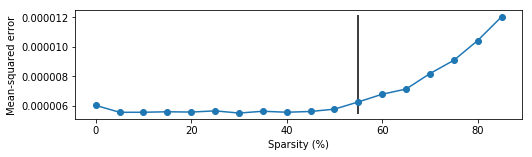

In [8]:
optimizer = optim.Adam(g.parameters())
group_lasso_training(g, optimizer, train_loader, args, plot=True)